In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import binarize

# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

# Load Credit Data. Explore a Bit

In [25]:
df = pd.read_csv("train.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_age,32581.0,NaN,NaN,NaN,27.7346,6.348078,20.0,23.0,26.0,30.0,144.0
person_income,32581.0,NaN,NaN,NaN,66074.84847,61983.119168,4000.0,38500.0,55000.0,79200.0,6000000.0
person_home_ownership,32581,4,RENT,16446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,31686.0,NaN,NaN,NaN,4.789686,4.14263,0.0,2.0,4.0,7.0,123.0
loan_intent,32581,6,EDUCATION,6453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,32581,7,A,10777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,32581.0,NaN,NaN,NaN,9589.371106,6322.086646,500.0,5000.0,8000.0,12200.0,35000.0
loan_int_rate,29465.0,NaN,NaN,NaN,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22
loan_status,32581.0,NaN,NaN,NaN,0.218164,0.413006,0.0,0.0,0.0,0.0,1.0
loan_percent_income,32581.0,NaN,NaN,NaN,0.170203,0.106782,0.0,0.09,0.15,0.23,0.83


A bunch of values, a few missing, mostly numeric. 

Here it is probably more reasonable to delete the rows where we have nulls, rather than the columns. For example, the interest rate has a few missing values, but if we are considering loans, it sounds important. 

In [5]:
df2 = df.dropna()
df2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_age,28638.0,NaN,NaN,NaN,27.727216,6.310441,20.0,23.0,26.0,30.0,144.0
person_income,28638.0,NaN,NaN,NaN,66649.371884,62356.447405,4000.0,39480.0,55956.0,80000.0,6000000.0
person_home_ownership,28638,4,RENT,14551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,28638.0,NaN,NaN,NaN,4.788672,4.154627,0.0,2.0,4.0,7.0,123.0
loan_intent,28638,6,EDUCATION,5704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,28638,7,A,9402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,28638.0,NaN,NaN,NaN,9656.493121,6329.683361,500.0,5000.0,8000.0,12500.0,35000.0
loan_int_rate,28638.0,NaN,NaN,NaN,11.039867,3.229372,5.42,7.9,10.99,13.48,23.22
loan_status,28638.0,NaN,NaN,NaN,0.2166,0.411935,0.0,0.0,0.0,0.0,1.0
loan_percent_income,28638.0,NaN,NaN,NaN,0.169488,0.106393,0.0,0.09,0.15,0.23,0.83


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


Explore numerical with pairplot.

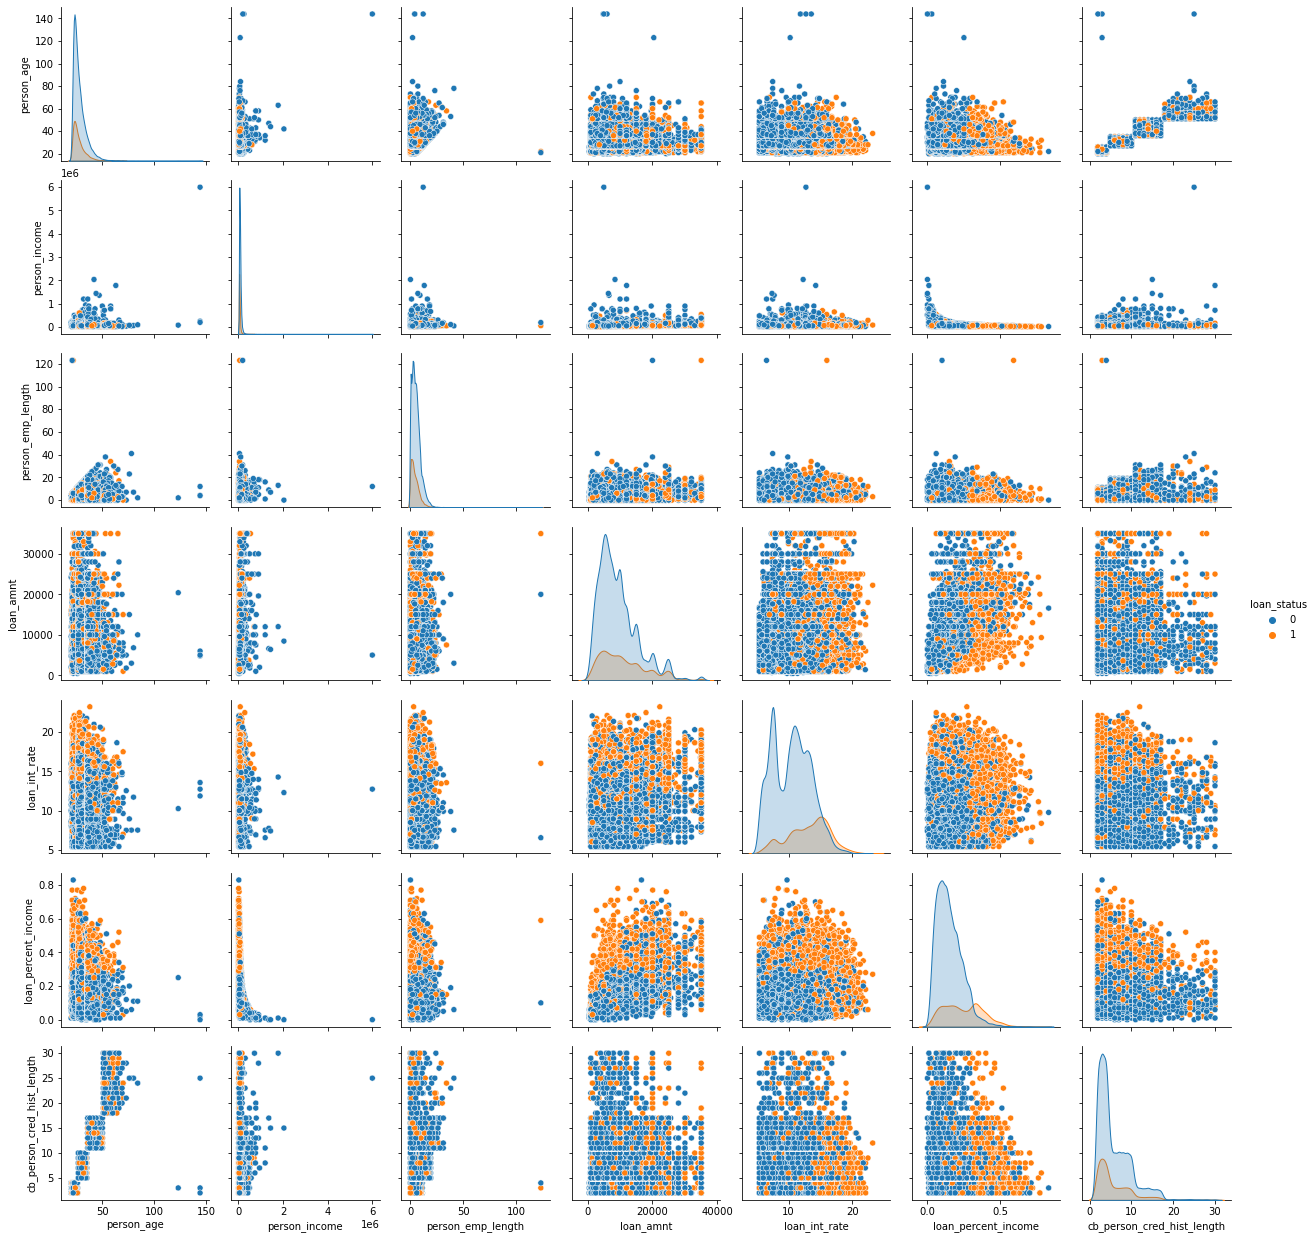

In [7]:
sns.pairplot(df2, hue="loan_status")

Looks like there are a few outliers. Make a simple filter to remove. 

We could also make something that filters based on X standard deviations, or similar. All the variables look roughly normal-ish, so that idea woudl be fine. We'd need to examine to decide on the threshold. 

For income, I'm going to filter at less than 1 million. It appears all the high income people have not defaulted, and based on domain knowledge, if you have a 1,000,000+ income, you can usually pay back these relatively small loans. 

In [8]:
df2 = df2[df2["person_age"]<100]
df2 = df2[df2["person_income"]<1000000]
df2 = df2[df2["person_emp_length"]<100]

In [9]:
#sns.pairplot(df2, hue="loan_status")

<AxesSubplot:>

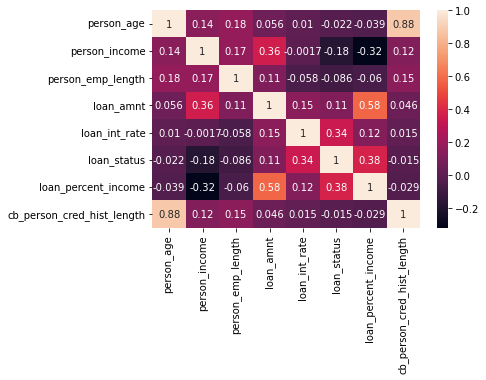

In [10]:
sns.heatmap(df2.corr(), annot=True)

Explore categorical

<AxesSubplot:xlabel='cb_person_default_on_file', ylabel='count'>

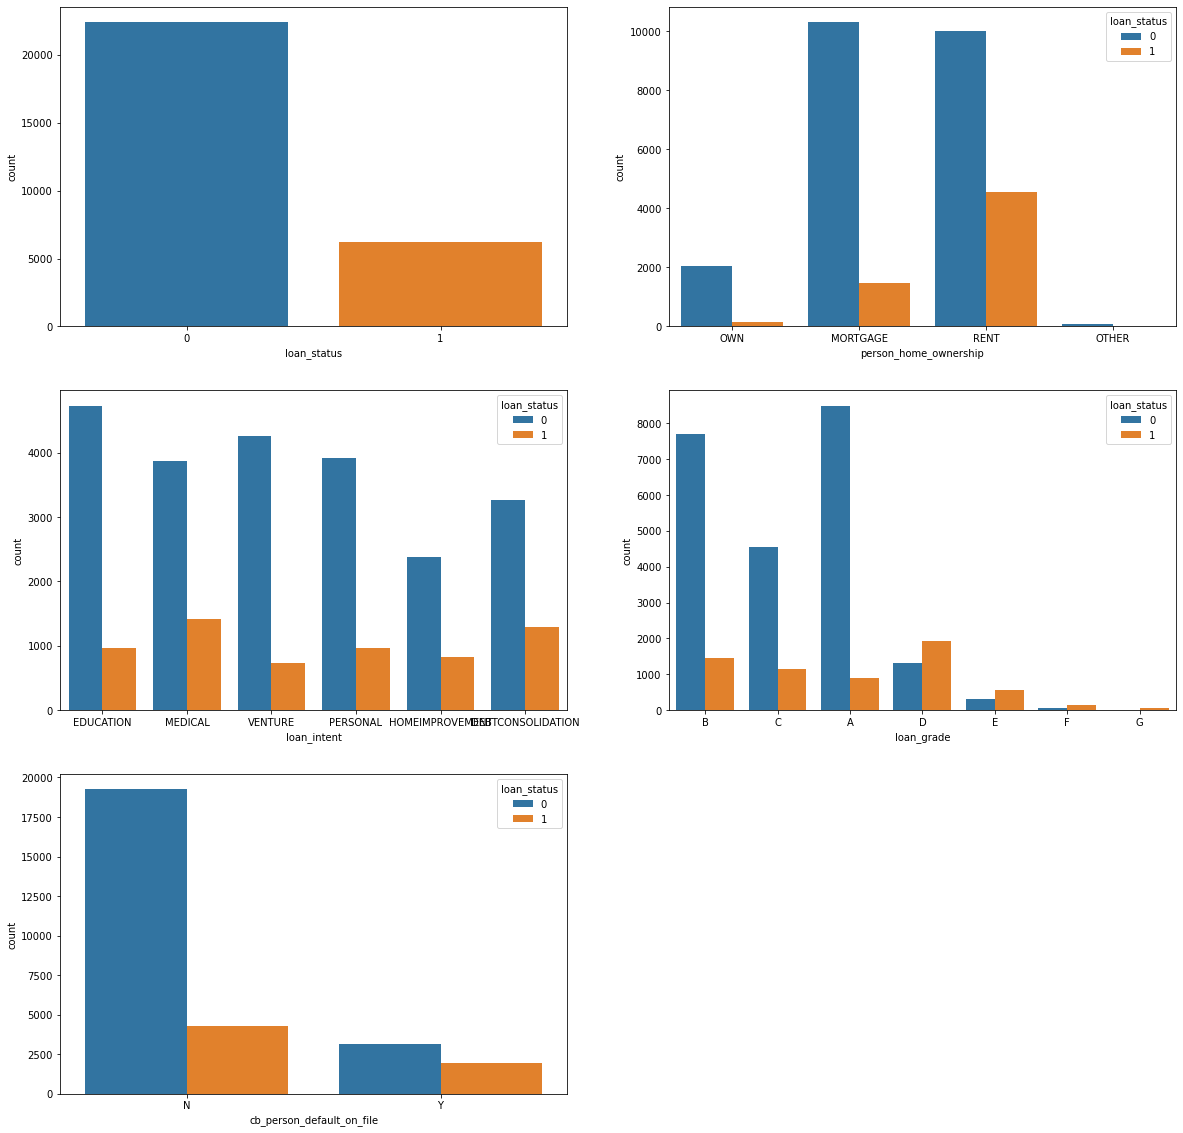

In [11]:
plt.figure(figsize=(20, 20))
thinkplot.PrePlot(6,3,2)
sns.countplot(data=df2, x="loan_status")
thinkplot.SubPlot(2)
sns.countplot(data=df2, x="person_home_ownership", hue="loan_status")
thinkplot.SubPlot(3)
sns.countplot(data=df2, x="loan_intent", hue="loan_status")
thinkplot.SubPlot(4)
sns.countplot(data=df2, x="loan_grade", hue="loan_status")
thinkplot.SubPlot(5)
sns.countplot(data=df2, x="cb_person_default_on_file", hue="loan_status")

Our target is imbalanced. We also see a few trends. People who own without a mortgage almost never default. Loan grades that are past D default more than they don't. People are much more likely to default if there's a default on file. 

We can deal with some of this. For example, I'm going to divide the loan grade into only two groups. A through C, and D+

In [12]:
df2["grade_2"] = df2["loan_grade"].isin(["A", "B", "C"])
df2.sample(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,grade_2
15258,25,127000,MORTGAGE,9.0,PERSONAL,B,6000,9.91,0,0.05,N,2,True
31020,46,74000,MORTGAGE,18.0,VENTURE,C,20000,12.68,0,0.27,Y,16,True
389,25,160000,OWN,5.0,VENTURE,B,15000,11.14,0,0.09,N,4,True
17148,24,92341,RENT,9.0,DEBTCONSOLIDATION,A,12000,7.51,0,0.13,N,4,True
20185,30,39000,RENT,6.0,MEDICAL,C,4000,15.96,0,0.10,N,9,True


In [13]:
df2.drop(columns={"loan_grade"}, inplace=True)

In [14]:
df2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_age,28626.0,NaN,NaN,NaN,27.708726,6.16648,20.0,23.0,26.0,30.0,84.0
person_income,28626.0,NaN,NaN,NaN,66125.198211,46951.228812,4000.0,39456.0,55826.0,80000.0,948000.0
person_home_ownership,28626,4,RENT,14546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,28626.0,NaN,NaN,NaN,4.779711,4.034943,0.0,2.0,4.0,7.0,41.0
loan_intent,28626,6,EDUCATION,5701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,28626.0,NaN,NaN,NaN,9655.417278,6328.37182,500.0,5000.0,8000.0,12500.0,35000.0
loan_int_rate,28626.0,NaN,NaN,NaN,11.040068,3.229376,5.42,7.9,10.99,13.48,23.22
loan_status,28626.0,NaN,NaN,NaN,0.216656,0.411974,0.0,0.0,0.0,0.0,1.0
loan_percent_income,28626.0,NaN,NaN,NaN,0.169524,0.106346,0.0,0.09,0.15,0.23,0.83
cb_person_default_on_file,28626,2,N,23525,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most of the distributions above look pretty skewed. What if we logged them to make them more normal?

<AxesSubplot:xlabel='person_income', ylabel='Density'>

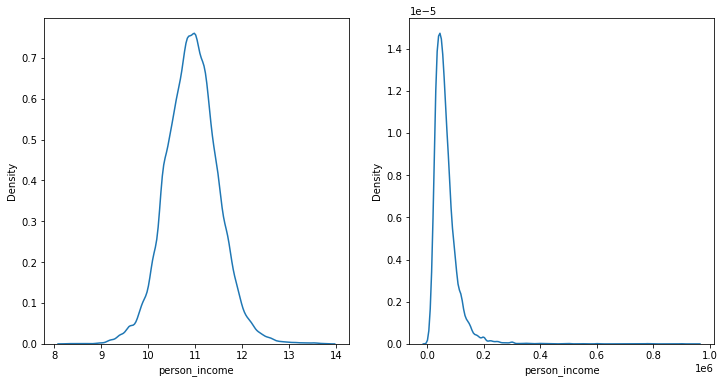

In [15]:
thinkplot.PrePlot(2,1,2)
sns.kdeplot(x=np.log(df2.person_income))
thinkplot.SubPlot(2)
sns.kdeplot(x=df2.person_income)

We are going to log transform some varaibles. 

In [16]:
df3 = df2.copy()

toTrans = ["person_income", "person_age", "loan_amnt", "loan_int_rate"]
for c in [c for c in df3.columns if df3[c].name in toTrans]:
    df3[c] = np.log(df3[c])

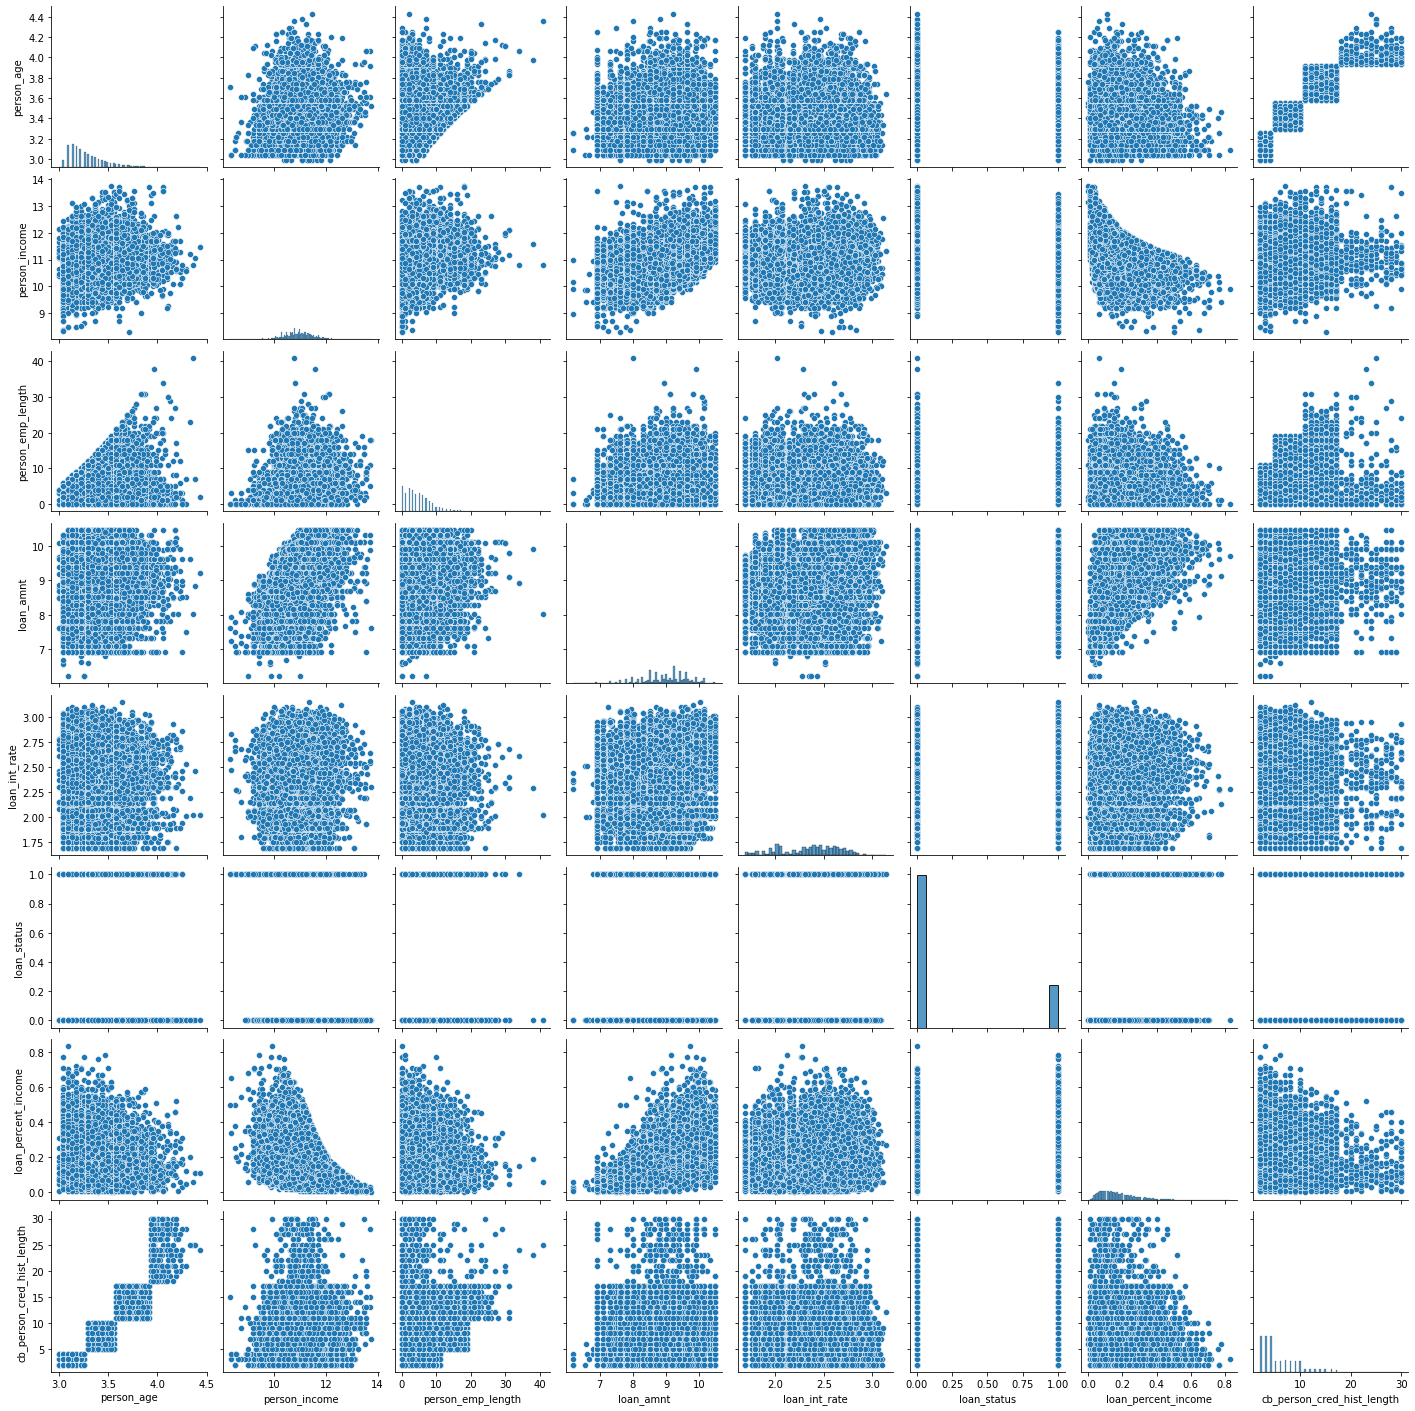

In [17]:
sns.pairplot(df3.drop(columns={"grade_2"}))

Ok. Try to predict. 

Process categorical

In [18]:
df3d = pd.get_dummies(df3, drop_first=True)
df3d.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,grade_2,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
1,3.044522,9.169518,5.0,6.907755,2.410542,0,0.10,2,True,0,1,0,1,0,0,0,0,0
2,3.218876,9.169518,1.0,8.612503,2.554899,1,0.57,3,True,0,0,0,0,0,1,0,0,0
3,3.135494,11.089805,4.0,10.463103,2.723267,1,0.53,2,True,0,0,1,0,0,1,0,0,0
4,3.178054,10.904119,8.0,10.463103,2.658159,1,0.55,4,True,0,0,1,0,0,1,0,0,1
5,3.044522,9.200290,2.0,7.824046,1.965713,1,0.25,2,True,0,1,0,0,0,0,0,1,0


The data is not balanced. We probably want to oversample to compensate. 

Note: I'm randomly picking an oversample method. I didn't test a bunch against each other

In [19]:
df3d["grade_2"] = df3d["grade_2"].astype("uint8")
#df3d.info()
df3d.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,grade_2,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
1,3.044522,9.169518,5.0,6.907755,2.410542,0,0.10,2,1,0,1,0,1,0,0,0,0,0
2,3.218876,9.169518,1.0,8.612503,2.554899,1,0.57,3,1,0,0,0,0,0,1,0,0,0
3,3.135494,11.089805,4.0,10.463103,2.723267,1,0.53,2,1,0,0,1,0,0,1,0,0,0
4,3.178054,10.904119,8.0,10.463103,2.658159,1,0.55,4,1,0,0,1,0,0,1,0,0,1
5,3.044522,9.200290,2.0,7.824046,1.965713,1,0.25,2,1,0,1,0,0,0,0,0,1,0


In [20]:
from imblearn.over_sampling import SMOTE
from collections import Counter
sampler = SMOTE()
y1 = np.array(df3d["loan_status"]).reshape(-1,1)
df3d.drop(columns={"loan_status"}, inplace=True)
x1 = np.array(df3d)

X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.33)
X_train_, y_train_ = sampler.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_))

Resampled dataset shape Counter({0: 15027, 1: 15027})


In [21]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_)
X_test_norm = scaler.transform(X_test)

In [22]:
model = LogisticRegression().fit(X_train_norm, y_train_.ravel())
predictions = model.predict(X_test_norm)
predictions = predictions.reshape(-1,1)
labels = binarize(predictions)

F1: 0.6610895735564171
Acc: 0.8241769874034085


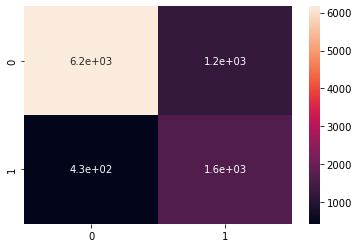

In [23]:
conf_matrix = confusion_matrix(y_test,labels)
sns.heatmap(conf_matrix, annot=True)

print("F1:",f1_score(y_test, labels))
print("Acc:",accuracy_score(y_test, labels))

### Accuracy Test

In [ ]:
d_test = pd.read_csv("test.csv")

######################
# Insert whatever you need to do to prep the data here. 
# It might be nothing if you have a big pipeline. 
# Ensure that at the end your data is in two arrays - xtest and ytest
# Ensure the name of your final model is "model"
# Each should contain the ENTIRE x or y dataset in the test data. 
#
# This part should be reusable - any dataset in this format should just run
# and generate predictions and accuracy stats. 
# Please DO NOT do any train-test splitting here. 
#######################

# This should work once you're done, as is. 
# uncomment the stuff below when ready to run.
#print("F1:",f1_score(ytest, prediction_labels))
#conf_matrix = confusion_matrix(ytest, prediction_labels)
#sns.heatmap(conf_matrix, annot=True)